# (26) Combine fits

**Motivation**: ...across different sim categories <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-MTMST/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-MTMST/figs')
tmp_dir = os.path.join(git_dir, 'jb-MTMST/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_MTMST'))
from vae.train_vae import TrainerVAE, ConfigTrainVAE
from vae.vae2d import VAE, ConfigVAE
from figures.fighelper import *
from analysis.glm import *


# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

## TODO: when training finished

Compare this local fit to fixate 2 that was imported from sigur. Which one is better? If the local one is better, run below readout.

In [2]:
escape_parenthesis('fixate2_k-32_z-20x[3,6,12]_enc(1x3)-dec(1x2)-pre(1x3)-post(1x3)/ep160-b600-lr(0.002)_beta(0.15:0x0.5)_lamb(0.0001)_gr(250.0)_(2023_04_26,23:01)')

fixate2_k-32_z-20x[3,6,12]_enc\(1x3\)-dec\(1x2\)-pre\(1x3\)-post\(1x3\)

ep160-b600-lr\(0.002\)_beta\(0.15:0x0.5\)_lamb\(0.0001\)_gr\(250.0\)_\(2023_04_26,23:01\)

## Copy fits to tmp dir

In [2]:
fits = [
    'fixate1_nf-420_(2023_04_27,20:20)',
    'fixate2_nf-420_(2023_04_27,13:57)',
    'transl0_nf-70_(2023_04_27,13:30)',
    'transl1_nf-420_(2023_04_27,13:00)',
    'transl2_nf-420_(2023_04_27,19:16)',
    'transl4_nf-420_(2023_04_27,07:52)',
    'Medium_obj1_nf-280_(2023_04_26,15:53)',
    'obj4_nf-280_(2023_04_26,18:21)',
    'terrain1_nf-210_(2023_04_27,12:50)',
    'terrain8_nf-420_(2023_04_26,22:51)',
    # TODO: fixate4,
]
copy_fits(fits, pjoin(tmp_dir, 'results_combined'))

## Load & analyze

In [3]:
df = []
perf = {}
for fit_name in fits:
    _df = f"summary_{fit_name}.df"
    _df = pjoin(tmp_dir, 'results_combined', _df)
    _df = pd.read_pickle(_df)
    k = _df['category'].unique().item()
    perf[k] = _df.perf.values
    df.append(_df)
df = pd.concat(df)
print({k: len(v) for k, v in perf.items()})

{
    'fixate1': 141,
    'fixate2': 141,
    'transl0': 141,
    'transl1': 141,
    'transl2': 141,
    'transl4': 141,
    'obj1': 141,
    'obj4': 141,
    'terrain1': 141,
    'terrain8': 141
}

In [4]:
sorted_data = sorted(
    zip(*(v for v in perf.values())),
    key=lambda x: x[0],
)
sorted_data = tuple(zip(*sorted_data))

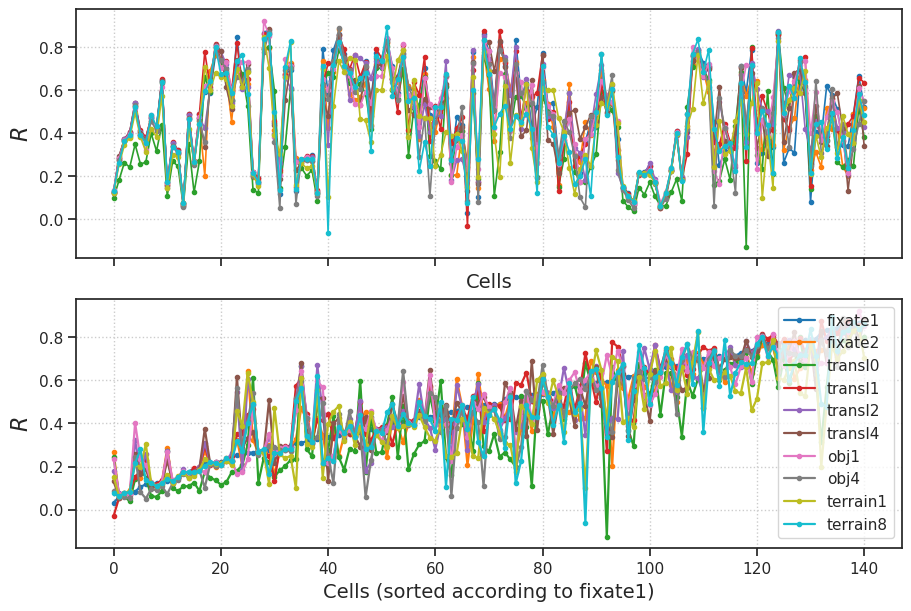

In [5]:
fig, axes = create_figure(2, 1, (9, 6), 'all', layout='constrained')

for k, v in perf.items():
    axes[0].plot(v, marker='.', lw=1.2, label=k)
axes[0].set_xlabel('Cells', fontsize=14)

for k, v in zip(perf, sorted_data):
    axes[1].plot(v, marker='.', lw=1.6, label=k)
axes[1].set_xlabel('Cells (sorted according to fixate1)', fontsize=14)
axes[1].legend()

for ax in axes.flat:
    ax.set_ylabel(r'$R$', fontsize=16)
    ax.grid()

plt.show()

In [6]:
x = np.stack([v for v in perf.values()])

counts = collections.Counter(np.argmax(x, axis=0))
counts = {
    list(perf)[i]: c for i, c
    in counts.most_common()
}
counts = {
    k: counts.get(k, 0) for k
    in list(counts) + list(perf)
}

percent = {
    k: np.round(100 * v / sum(counts.values()), 1)
    for k, v in counts.items()
}
print(percent)

{
    'transl1': 22.7,
    'fixate1': 14.2,
    'obj1': 12.8,
    'transl2': 9.9,
    'terrain8': 9.2,
    'transl4': 8.5,
    'terrain1': 7.8,
    'fixate2': 6.4,
    'obj4': 5.0,
    'transl0': 3.5
}

In [7]:
best = x.max(0)
x = best.mean()
x

0.5589450858078276

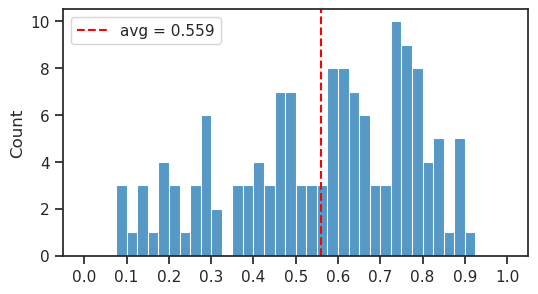

In [8]:
fig, ax = create_figure(1, 1, (6, 3.2))
sns.histplot(best, bins=np.linspace(0, 1, 41), ax=ax)
ax.axvline(x, color='r', ls='--', label=f"avg = {x:0.3f}")
ax.locator_params(axis='x', nbins=11)
ax.legend()
plt.show()

In [9]:
100 * (559 - 251) / 251

122.70916334661355

## More plots

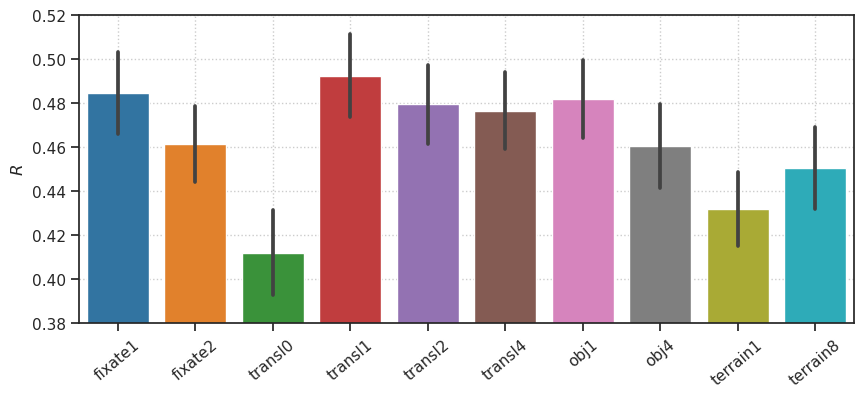

In [10]:
fig, ax = create_figure(1, 1, (10, 4))
sns.barplot(data=df, x='category', y='perf', errorbar='se', ax=ax)
ax.set(xlabel='', ylabel=r'$R$', ylim=(0.38, 0.52))
ax.tick_params(axis='x', rotation=40)
ax.grid()
plt.show()

## Get df best

In [30]:
df_best = collections.defaultdict(list)
for expt in df['expt'].unique():
    _df1 = df.loc[df['expt'] == expt]
    for cell in _df1['cell'].unique():
        _df2 = _df1.loc[_df1['cell'] == cell]
        best_i = _df2['perf'].argmax()
        best = dict(_df2.iloc[best_i])
        best['perf_best'] = best.pop('perf')
        best['perf_mu'] = _df2['perf'].mean()
        best['perf_sd'] = _df2['perf'].std()
        for k, v in best.items():
            df_best[k].append(v)
df_best = pd.DataFrame(df_best)

In [31]:
df_best

,category,nf,root,expt,cell,max_perf,log_alpha,best_lag,perf_best,perf_mu,perf_sd
0,obj1,280,YUWEI,clu036,0,NaN,5.0,5,0.136978,0.124710,0.010827
1,transl4,420,YUWEI,clu037,0,NaN,2.0,4,0.295079,0.268079,0.032203
2,fixate1,420,YUWEI,clu038,0,NaN,3.0,0,0.374930,0.356659,0.033544
3,transl1,420,YUWEI,clu039,0,NaN,3.0,1,0.407124,0.379822,0.048944
4,transl2,420,YUWEI,clu040,0,NaN,-10.0,3,0.542245,0.509416,0.057991
...,...,...,...,...,...,...,...,...,...,...,...
136,terrain1,210,YUWEI,ytu029,19,0.941254,1.0,3,0.481060,0.370724,0.076897
137,transl1,420,YUWEI,ytu029,20,0.958395,3.0,5,0.444701,0.270336,0.096081
138,fixate2,420,YUWEI,ytu029,21,0.846710,-2.0,1,0.492103,0.390104,0.079458
139,fixate1,420,YUWEI,ytu029,22,0.930033,2.0,8,0.665234,0.571026,0.070122


In [32]:
sorted_data = sorted(zip(
    df_best['perf_best'],
    df_best['perf_mu'],
    df_best['perf_sd'],
), key=lambda x: x[0])
sorted_data = list(map(
    lambda t: np.array(t),
    zip(*sorted_data),
))

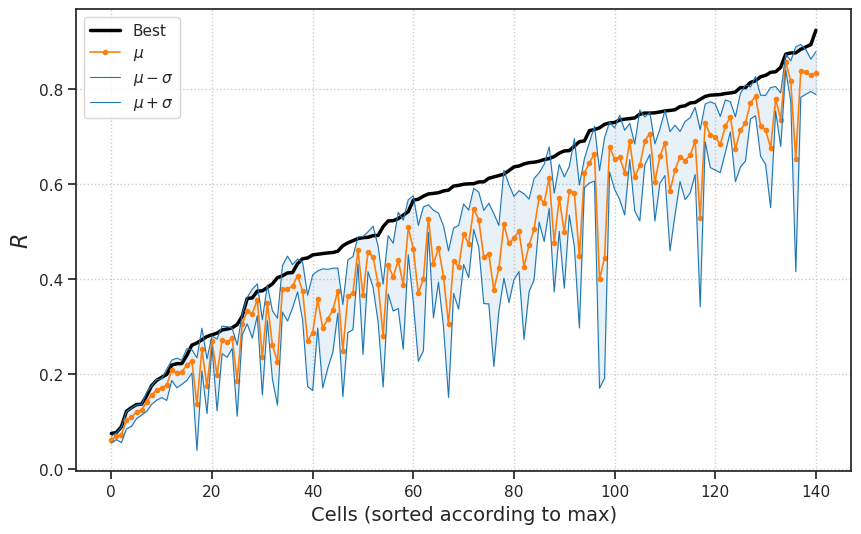

In [33]:
fig, ax = create_figure(1, 1, (10, 6))
ax.plot(sorted_data[0], lw=2.5, color='k', label='Best')
ax.plot(sorted_data[1], lw=1.2, color='C1', marker='.', label=r'$\mu$')

lower = sorted_data[1] - sorted_data[2]
higher = sorted_data[1] + sorted_data[2]
ax.plot(lower, lw=0.8, color='C0', label=r'$\mu - \sigma$')
ax.plot(higher, lw=0.8, color='C0', label=r'$\mu + \sigma$')
ax.fill_between(
    x=range(len(df_best)),
    y1=lower,
    y2=higher,
    color='C0',
    alpha=0.1,
)
ax.set_xlabel('Cells (sorted according to max)', fontsize=14)
ax.set_ylabel(r'$R$', fontsize=16)
ax.legend()
ax.grid()
plt.show()

In [35]:
df_best.iloc[inds[:10]]

,category,nf,root,expt,cell,max_perf,log_alpha,best_lag,perf_best,perf_mu,perf_sd
118,obj1,280,YUWEI,ytu028,8,0.328052,12.0,10,0.718525,0.399699,0.228919
79,transl1,420,YUWEI,clu292,2,0.805540,4.0,10,0.587479,0.305260,0.154100
40,transl1,420,YUWEI,clu183,0,0.927126,3.0,7,0.725815,0.444699,0.253287
17,transl1,420,YUWEI,clu088,0,0.646108,8.0,4,0.778417,0.528384,0.186210
71,transl4,420,YUWEI,clu267,6,0.880980,1.0,5,0.689412,0.447823,0.150396
113,transl4,420,YUWEI,clu295,11,0.891785,14.0,11,0.615207,0.377185,0.160740
86,transl4,420,YUWEI,clu293,1,0.887323,-4.0,10,0.510461,0.281390,0.108245
72,transl1,420,YUWEI,clu267,7,0.955361,2.0,5,0.876347,0.652552,0.236587
83,terrain1,210,YUWEI,clu292,12,0.770807,1.0,12,0.470403,0.249841,0.097090
120,fixate2,420,YUWEI,ytu029,0,0.331085,4.0,1,0.642557,0.426674,0.153278


In [38]:
df_best.iloc[df_best['perf_best'].argsort()[::-1][:10]]

,category,nf,root,expt,cell,max_perf,log_alpha,best_lag,perf_best,perf_mu,perf_sd
28,obj1,280,YUWEI,clu116,0,0.835483,16.0,0,0.923867,0.833675,0.045101
51,terrain8,420,YUWEI,clu221,3,0.900849,-10.0,6,0.893667,0.829131,0.034021
42,obj4,280,YUWEI,clu209,1,0.923722,8.0,5,0.888635,0.836093,0.046829
29,transl4,420,YUWEI,clu120,0,0.967720,3.0,3,0.883813,0.838387,0.055588
72,transl1,420,YUWEI,clu267,7,0.955361,2.0,5,0.876347,0.652552,0.236587
69,transl1,420,YUWEI,clu267,4,0.979806,2.0,5,0.876143,0.817082,0.042463
124,transl2,420,YUWEI,ytu029,4,0.935583,-8.0,3,0.873508,0.856746,0.016747
23,fixate1,420,YUWEI,clu104,0,0.980831,0.0,4,0.845799,0.735943,0.056409
109,terrain8,420,YUWEI,clu295,4,0.929612,5.0,5,0.836597,0.779707,0.025680
75,fixate1,420,YUWEI,clu267,11,0.850368,-10.0,6,0.835265,0.676980,0.126413


### Pie chart

In [15]:
labels, vals = zip(*collections.Counter(
    df_best['category']).most_common())
vals = [100 * e / sum(vals) for e in vals]

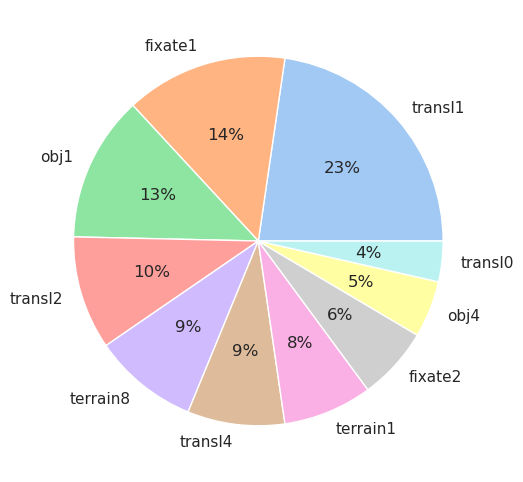

In [16]:
fig, ax = create_figure(1, 1, (8, 6))
ax.pie(
    x=vals,
    labels=labels,
    colors=sns.color_palette('pastel')[:len(labels)],
    autopct='%.0f%%',
)
plt.show()

### Summary of results

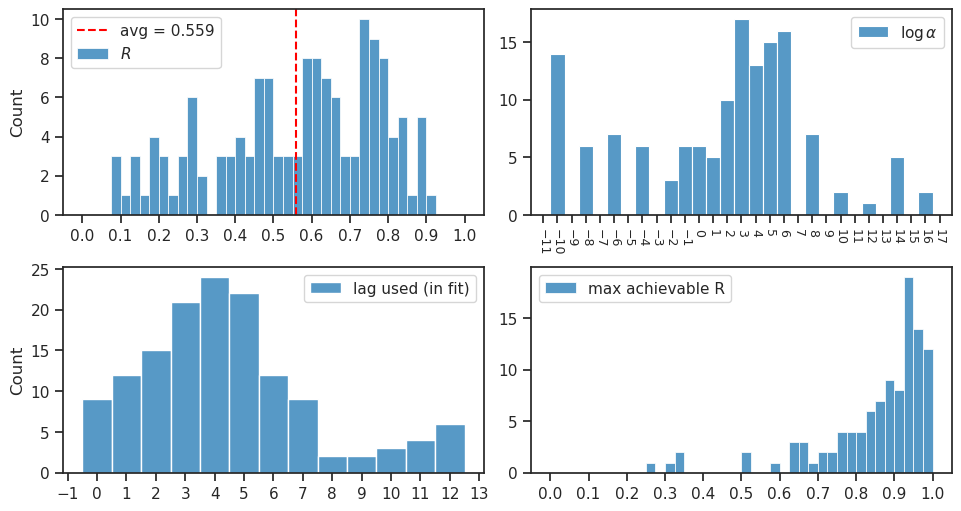

In [36]:
show_neural_results(df_best, 'perf_best');